In [1]:
from lib import *
import pandas as pd
import matplotlib.pyplot as plt

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

try:
    dfs = load_data_bq()
except Exception as e:
    dfs = load_data_db()
df_contratos = dfs["contract"].sort_values("created_at")
from datetime import timedelta
df_contratos['created_at'] = df_contratos['created_at'].dt.strftime("%Y-%m-%d")
df_contratos_original = df_contratos.copy()
#31s

Erro ao executar a query contract_canceled.sql: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/formal-purpose-354320/jobs?prettyPrint=false: Access Denied: Project formal-purpose-354320: User does not have bigquery.jobs.create permission in project formal-purpose-354320.

Location: None
Job ID: 0417e3e5-f166-4c8d-a8d7-52ef8bc37a41

Erro geral: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/formal-purpose-354320/jobs?prettyPrint=false: Access Denied: Project formal-purpose-354320: User does not have bigquery.jobs.create permission in project formal-purpose-354320.

Location: None
Job ID: 0417e3e5-f166-4c8d-a8d7-52ef8bc37a41

Conexão estabelecida com sucesso!


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Função para treinar o modelo polinomial
def train_poly_model(df, degree=2, plot=True):
    """
    Treina um modelo de regressão polinomial a partir de um DataFrame.
    
    Parâmetros:
      - df: DataFrame contendo a coluna 'created_at'. Os dados serão agrupados por data e contados.
      - degree: Grau do polinômio para ajuste (default=2).
      - plot: Se True, plota os dados originais e o ajuste do modelo.
      
    Retorna:
      - df_grouped: DataFrame agrupado com as colunas 'created_at', 'count' e 'date_num' (valor ordinal da data).
      - poly: Objeto np.poly1d contendo o modelo ajustado.
    """
    df_copy = df.copy()
    df_copy['created_at'] = pd.to_datetime(df_copy['created_at'])
    df_grouped = df_copy.groupby('created_at').size().reset_index(name='count')
    df_grouped = df_grouped.sort_values('created_at')
    
    # Converter as datas para números ordinais para ajuste
    df_grouped['date_num'] = df_grouped['created_at'].apply(lambda x: x.toordinal())
    x = df_grouped['date_num'].values
    y = df_grouped['count'].values
    
    coef = np.polyfit(x, y, degree)
    poly = np.poly1d(coef)
    
    if plot:
        x_range = np.linspace(x.min(), x.max(), 1000)
        y_range = poly(x_range)
        x_range_dates = [datetime.fromordinal(int(val)) for val in x_range]
        
        plt.figure(figsize=(10, 6))
        plt.scatter(df_grouped['created_at'], y, label='Dados', color='black')
        plt.plot(x_range_dates, y_range, label=f'Ajuste Polinomial (grau {degree})')
        plt.xlabel("Data de criação (created_at)")
        plt.ylabel("Count")
        plt.title("Ajuste Polinomial aos Dados")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # display(df_grouped.tail(365))


    return df_grouped, poly

# Função para predição com o modelo polinomial treinado
def predict_poly_model(dates, poly):
    """
    Aplica o modelo polinomial treinado para prever os valores para uma lista ou coluna de datas.
    
    Parâmetros:
      - dates: Sequência (list ou Series) de datas (pode ser datetime ou string).
      - poly: Objeto np.poly1d do modelo polinomial treinado.
      
    Retorna:
      - df_pred: DataFrame com colunas 'created_at' e 'predicted'.
    """
    dates = pd.to_datetime(dates)
    date_ordinals = dates.apply(lambda x: x.toordinal()).values
    predictions = poly(date_ordinals)
    
    df_pred = pd.DataFrame({
        'created_at': dates,
        'predicted': predictions
    })
    return df_pred

# Função para atualizar os contratos (reamostragem com substituição, duplicação e predição)
def update_contracts(df_contratos, poly, extrapolation_days=7*52):
    """
    Atualiza o DataFrame de contratos:
      1. Reamostra com reposição os últimos extrapolation_days (padrão: 364 dias).
      2. Duplica os contratos desses últimos dias, somando extrapolation_days à data.
      3. Concatena os novos contratos ao DataFrame original.
      4. Prediz os valores (weights) para todas as datas usando o modelo polinomial.
      5. Escala os weights dividindo pelo valor predito na última data.
      6. Garante que os weights sejam pelo menos 1.
    
    Parâmetros:
      - df_contratos: DataFrame original contendo a coluna 'created_at'.
      - poly: Objeto np.poly1d do modelo polinomial treinado.
      - extrapolation_days: Número de dias a somar para criar os novos contratos (default: 7*52 = 364).
      
    Retorna:
      - df_contratos atualizado com a coluna "weights".
    """
    df_contratos = df_contratos.copy()
    df_contratos['created_at'] = pd.to_datetime(df_contratos['created_at'])
    df_contratos['weights'] = predict_poly_model(df_contratos['created_at'], poly)["predicted"]


    # Selecionar os contratos dos últimos extrapolation_days dias
    max_date = df_contratos['created_at'].max()
    limite = max_date - pd.Timedelta(days=extrapolation_days)
    df_ultimos = df_contratos[df_contratos['created_at'] >= limite].copy()
    
    
    # Criar novos contratos com data atualizada (somando extrapolation_days)
    df_novos = df_ultimos.copy()
    df_novos['created_at'] = df_novos['created_at'] + pd.Timedelta(days=extrapolation_days)
    df_novos['weights'] = predict_poly_model(df_novos['created_at'], poly)["predicted"]
    df_novos['weights'] = df_novos['weights'] / df_contratos.tail(1)['weights'].values[0]
    df_contratos['weights'] = 1
    # Concatenar os novos contratos ao DataFrame original
    df_contratos = pd.concat([df_contratos, df_novos], ignore_index=True)

    return df_contratos





/tmp/ipykernel_162880/1943436048.py:30: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x, y, degree)


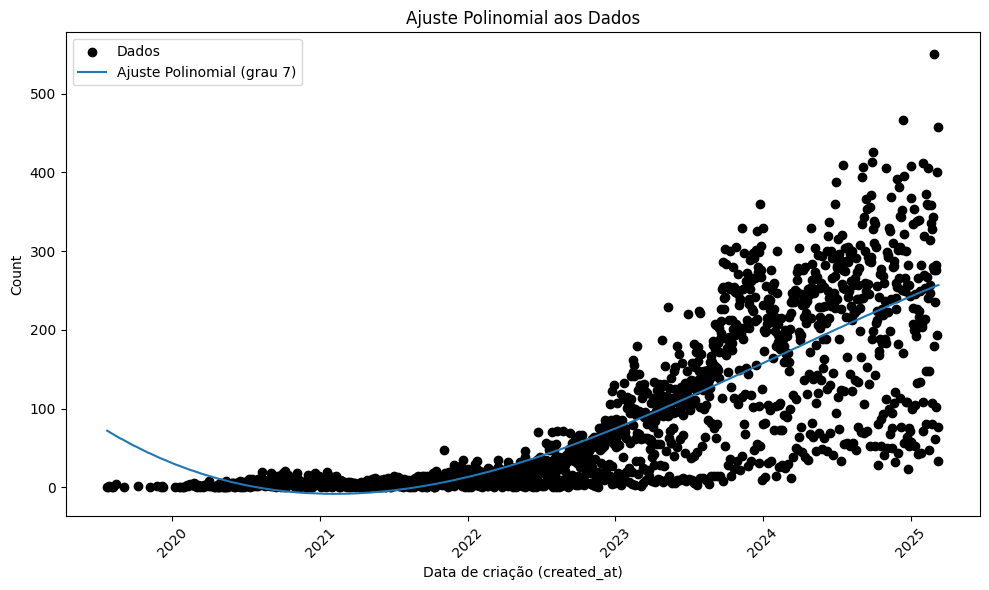

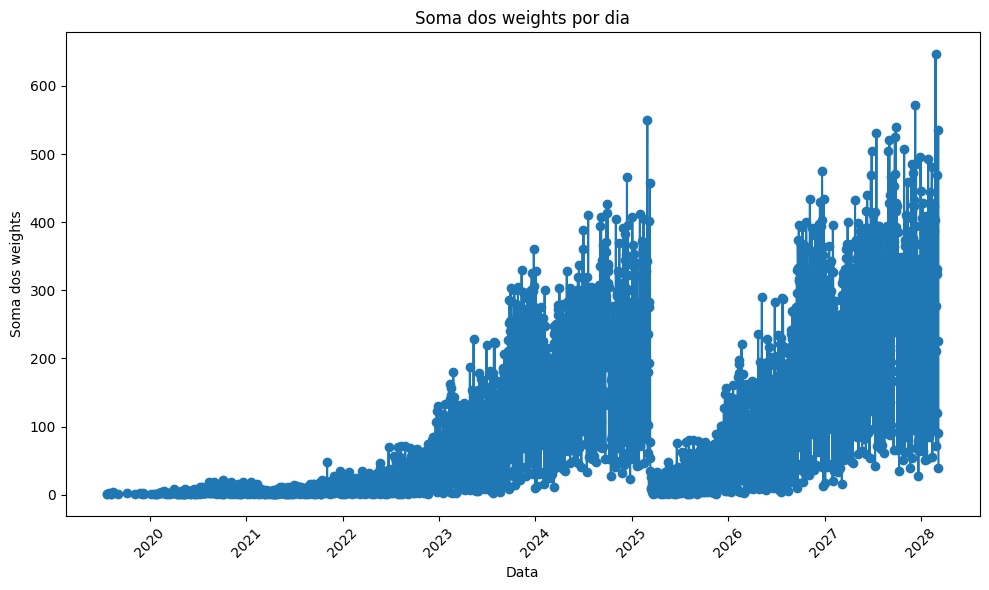

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df_contratos = df_contratos_original.copy()
df_grouped, modelo = train_poly_model(df_contratos, degree=7, plot=True)
df_contratos = update_contracts(df_contratos, modelo, extrapolation_days=7*52 * 3)

df = df_contratos.copy()

# Converter a coluna de datas para datetime (ajuste o nome da coluna se necessário)
df['created_at'] = pd.to_datetime(df['created_at'])

# Agrupar os dados por dia e somar os valores da coluna "weights"
df_grouped = df.groupby(df['created_at'].dt.date)['weights'].sum().reset_index()
# Converter a coluna de datas de volta para datetime para facilitar a plotagem
df_grouped['created_at'] = pd.to_datetime(df_grouped['created_at'])

# Plotar a soma dos weights por dia
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['created_at'], df_grouped['weights'], marker='o')
plt.xlabel("Data")
plt.ylabel("Soma dos weights")
plt.title("Soma dos weights por dia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




/tmp/ipykernel_162880/1943436048.py:30: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x, y, degree)


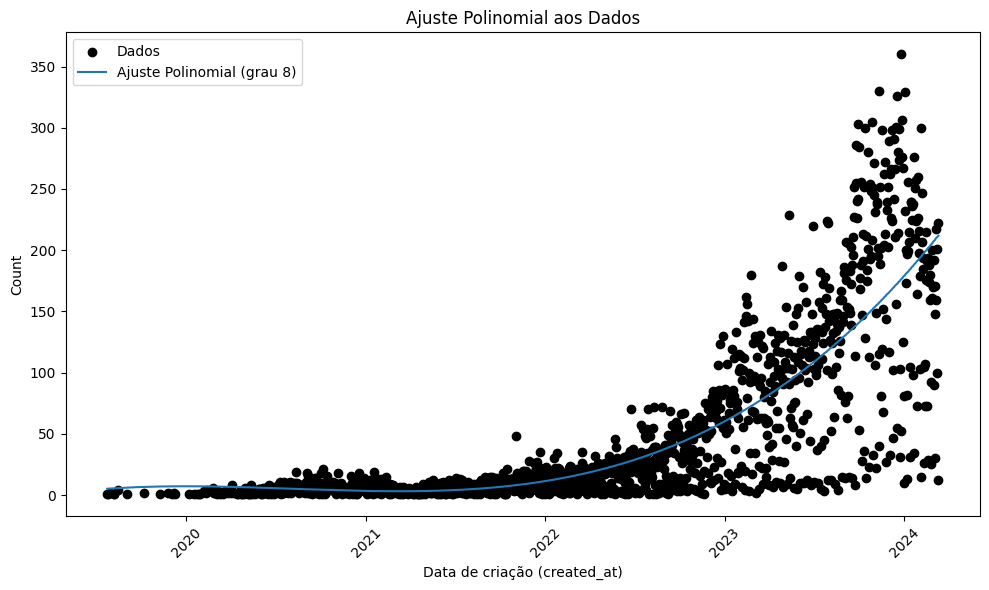

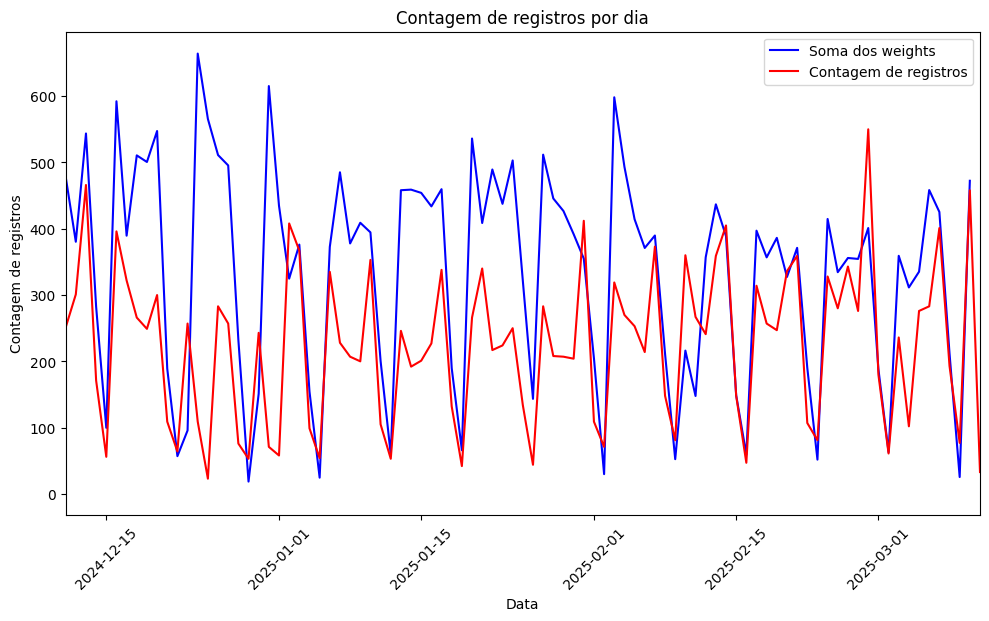

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Criar uma cópia do DataFrame original para preservar os dados originais
df_contratos = df_contratos_original.copy()
limite = pd.to_datetime(df_contratos['created_at'].max()) - pd.Timedelta(days=365)
mask = pd.to_datetime(df_contratos['created_at']) <= limite
df_contratos = df_contratos[mask]

# Treina um modelo polinomial de grau 8 com os dados filtrados e gera um gráfico
df_grouped, modelo = train_poly_model(df_contratos, degree=8, plot=True)

# Atualiza os contratos com a previsão do modelo para os próximos 52 semanas
df_contratos = update_contracts(df_contratos, modelo, extrapolation_days=7*52)

# Criar uma cópia do DataFrame atualizado
df = df_contratos.copy()

# Converter a coluna de datas para o formato datetime para facilitar a manipulação
df['created_at'] = pd.to_datetime(df['created_at'])

# Criar o gráfico da soma dos "weights" por dia
plt.figure(figsize=(10, 6))

# Agrupar os dados por data e somar os valores de "weights"
df_grouped = df.groupby(df['created_at'].dt.date)['weights'].sum().reset_index()
df_grouped['created_at'] = pd.to_datetime(df_grouped['created_at'])

# Plotar a soma dos "weights" ao longo do tempo
plt.plot(df_grouped['created_at'], df_grouped['weights'], color="blue", label="Soma dos weights")

# Configuração dos eixos e título do gráfico
plt.xlabel("Data")
plt.ylabel("Soma dos weights")
plt.title("Soma dos weights por dia")
plt.xticks(rotation=45)
plt.tight_layout()

# Criar um novo DataFrame para analisar a contagem de registros por dia
df = df_contratos_original.copy()
df['created_at'] = pd.to_datetime(df['created_at'])

# Agrupar os registros por data e contar a quantidade de ocorrências
df_grouped = df.groupby(df['created_at'].dt.date).size().reset_index(name='count')
df_grouped['created_at'] = pd.to_datetime(df_grouped['created_at'])

# Plotar a contagem de registros ao longo do tempo
plt.plot(df_grouped['created_at'], df_grouped['count'], color="red", label="Contagem de registros")

# Configuração dos eixos e título do gráfico
plt.xlabel("Data")
plt.ylabel("Contagem de registros")
plt.title("Contagem de registros por dia")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Ajustar limites do eixo X para exibir apenas os dados do último ano
max_date = df['created_at'].max()
min_date = max_date - pd.Timedelta(days=90)
plt.xlim(min_date, max_date)

# Exibir o gráfico
plt.show()
